# Preprocess Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.cluster import KMeans
from statsbombpy import sb
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Constants & Configuration
PITCH_LENGTH = 105.0  # Meters
PITCH_WIDTH = 68.0    # Meters
METRIC_X_RANGE = [-PITCH_LENGTH / 2, PITCH_LENGTH / 2]
METRIC_Y_RANGE = [-PITCH_WIDTH / 2, PITCH_WIDTH / 2]

ugp_data_path = 'data/ugp/17985.ugp'

## SoccerCPD Data Analysis

We first look at the SoccerCPD data, checking for data quality, missing values, and consistency (e.g., high frequency jitter from GPS noise, Gaussian assumption).

We introduce the FitogetherDiagnosis class to help with this process.

In [3]:
class FitogetherDiagnosis:
    """
    Handles loading, diagnosis, and validation of 10Hz GPS tracking data used by the Fitogether Inc. (SoccerCPD) researchers.
    """
    
    def __init__(self, data_path=None):
        self.data_path = data_path
        self.data = None

    def check_and_fix_orientation(self):
        """
        Ensures the team is always attacking from left to right in metric coordinates.
        """
        print("\n--- [Fitogether] Orientation Check ---")
        df = self.data

        medians = df.groupby('player_id')['x'].median()
        min_x_player = medians.min()
        max_x_player = medians.max()
        print(f"Player X Medians Range: {min_x_player:.2f} to {max_x_player:.2f}")

        # Check where the deepest player is
        # Since there are no goalkeepers, we assume the deepest player indicates orientation (attackers go right)
        if abs(min_x_player) > abs(max_x_player):
            df['x'] = -df['x']
            df['y'] = -df['y']
            print("Orientation corrected: Team now attacks left to right.")
            self.data = df
        else:
            print("Orientation is left to right. No changes made.")

    def load_or_generate_data(self):
        """
        Loads data from file if path exists, otherwise generates synthetic 
        10Hz player tracking data to demonstrate the diagnosis tools.
        """
        if self.data_path and pd.io.common.file_exists(self.data_path):
            print(f"Loading data from {self.data_path}.")
            # K-League (SoccerCPD) data is available in a .ugp format.
            self.data = pd.read_pickle(self.data_path)
            
            if 'unixtime' in self.data.columns:
                self.data = self.data.rename(columns={'unixtime': 'frame'})

            # Convert from cm to m if necessary
            if self.data['x'].abs().max() > 150:
                self.data['x'] = self.data['x'] / 100.0
                self.data['y'] = self.data['y'] / 100.0

            # Transform from SoccerCPD coordinates to Metric coordinates
            self.data['x'] = (self.data['x'] / 120.0 * PITCH_LENGTH) - (PITCH_LENGTH / 2)
            self.data['y'] = (PITCH_WIDTH / 2) - (self.data['y'] / 80.0 * PITCH_WIDTH)

            self.check_and_fix_orientation()

        else:
            print("Data file not found. Generating synthetic 10Hz data.")
            self.data = self._generate_synthetic_data()
            
        return self.data

    def _generate_synthetic_data(self, n_frames=5400, n_players=10):
        """
        Generates realistic-looking dummy tracking data.
        """
        records = []
        
        # Define 4-3-3 Formation Centers (10 Outfield Players)
        # Coordinates assume metric, center origin (0,0)
        # Order: LB, LCB, RCB, RB, CDM, LCM, RCM, LW, CF, RW
        formation_433 = np.array([
            [-10.0,  20.0],  # Left Back
            [-20.0,   7.0],  # Left Center Back
            [-20.0,  -7.0],  # Right Center Back
            [-10.0, -20.0],  # Right Back
            [ -5.0,   0.0],  # Defensive Mid
            [ 10.0,  15.0],  # Left Center Mid
            [ 10.0, -15.0],  # Right Center Mid
            [ 30.0,  25.0],  # Left Wing
            [ 35.0,   0.0],  # Center Forward
            [ 30.0, -25.0]   # Right Wing
        ])

        # Initialize player role centers
        if n_players <= len(formation_433):
            role_centers = formation_433[:n_players].copy()
        else:
            # Add random positions if more than 10 players requested
            extra_needed = n_players - len(formation_433)
            extra_roles = np.random.uniform(-30, 30, size=(extra_needed, 2))
            role_centers = np.vstack([formation_433, extra_roles])

        for t in range(n_frames):
            for p_id in range(n_players):
                # Add Gaussian noise (position) and high-freq jitter
                center = role_centers[p_id]
                noise = np.random.normal(0, 4, 2)  # Tactical movement
                jitter = np.random.normal(0, 0.1, 2) # GPS Jitter
                
                # Drift centers slightly over time
                role_centers[p_id] += np.random.normal(0, 0.05, 2)
                
                pos = center + noise + jitter
                
                # Clip to pitch
                pos[0] = np.clip(pos[0], *METRIC_X_RANGE)
                pos[1] = np.clip(pos[1], *METRIC_Y_RANGE)
                
                records.append({
                    'player_id': p_id,
                    'frame': t,
                    'x': pos[0],
                    'y': pos[1],
                    'speed': np.linalg.norm(np.random.normal(0, 2, 2))
                })
        return pd.DataFrame(records)

    def diagnose_signal_quality(self):
        """
        Performs data diagnosis:
        1. Missing Value Check
        2. High-Frequency Jitter Analysis
        """
        print("\n--- [Fitogether] Signal Diagnosis ---")
        df = self.data
        
        # Missing Values
        missing_count = df[['x', 'y']].isnull().sum().sum()
        total_points = len(df) * 2
        missing_pct = (missing_count / total_points) * 100
        
        print(f"Completeness Check: {100 - missing_pct:.4f}% available (Missing: {missing_pct:.4f}%)")
        if missing_pct > 1.0:
            print("Warning: Missing data exceeds 1% threshold. Interpolation required.")
        else:
            print("Signal completeness is acceptable.")

        unique_players = df['player_id'].unique()
        if len(unique_players) == 0:
            print("Error: No player data found.")
            return
        
        sample_player_id = unique_players[0]

        # Jitter Analysis (Velocity Variance): Calculate frame-to-frame displacement for a sample player
        p0 = df[df['player_id'] == sample_player_id].sort_values('frame')
        displacements = np.diff(p0[['x', 'y']].values, axis=0)
        # 10Hz => dt = 0.1s
        inst_speeds = np.linalg.norm(displacements, axis=1) * 10 
        
        speed_std = np.std(inst_speeds)
        print(f"Jitter Analysis (Speed Std Dev) for player {sample_player_id}: {speed_std:.2f} m/s")
        if speed_std > 1: # Threshold for "noisy"
            print("High-frequency jitter detected (consistent with raw GPS).")

    def verify_gaussian_assumption(self):
        """
        Verifies the Gaussian assumption (Normality) of player roles.
        Since we use our own pipeline, we use K-Means to approximate 'roles' and test their distribution.
        """
        print("\n--- [Fitogether] Gaussian Assumption Check ---")
        df = self.data
        
        # Approximate Roles using K-Means
        coords = df[['x', 'y']].values
        kmeans = KMeans(n_clusters=10, random_state=0).fit(coords)
        df['proxy_role'] = kmeans.labels_
        
        # Shapiro-Wilk Test on the largest cluster
        # Sample one role
        role_id = df['proxy_role'].value_counts().idxmax()
        role_data = df[df['proxy_role'] == role_id][['x', 'y']]
        
        # Downsample for Shapiro (it's sensitive to large N)
        sample = role_data.sample(n=min(500, len(role_data)), random_state=0)
        
        stat_x, p_x = shapiro(sample['x'])
        stat_y, p_y = shapiro(sample['y'])
        
        print(f"Testing Role Cluster #{role_id} (N={len(sample)}):")
        print(f"P-value (X-coord): {p_x:.2e}")
        print(f"P-value (Y-coord): {p_y:.2e}")
        
        if p_x < 0.05 or p_y < 0.05:
            print("Significant deviation from Normality (p < 0.05) found.")
        else:
            print("Data is consistent with Gaussian assumption.")

In [4]:
# Fitogether Analysis
fitogether = FitogetherDiagnosis(data_path=ugp_data_path)
gps_data = fitogether.load_or_generate_data()
fitogether.diagnose_signal_quality()
fitogether.verify_gaussian_assumption()

Loading data from data/ugp/17985.ugp.

--- [Fitogether] Orientation Check ---
Player X Medians Range: -18.66 to 2.92
Orientation corrected: Team now attacks left to right.

--- [Fitogether] Signal Diagnosis ---
Completeness Check: 100.0000% available (Missing: 0.0000%)
Signal completeness is acceptable.
Jitter Analysis (Speed Std Dev) for player 1365.0: 1.18 m/s
High-frequency jitter detected (consistent with raw GPS).

--- [Fitogether] Gaussian Assumption Check ---
Testing Role Cluster #3 (N=500):
P-value (X-coord): 2.54e-07
P-value (Y-coord): 3.49e-09
Significant deviation from Normality (p < 0.05) found.


We find that the SoccerCPD data is complete with minimal missing values. We observe high-frequency jitter in the player trajectories, consistent with raw GPS data. There are significant deviations from the Gaussian assumption in player movements, as players hold positions (zones, often rectangular or irregular) and make tactical maneuvers. This indicates the need for robust modeling techniques, therefore justifies the use of the Change Point Detection (CPD) approach.

## StatsBomb Data Analysis

We now explore the StatsBomb event data used for the 'Messi Effect' analysis. We check for data completeness, coordinate transformations, and handling of sparsity due to event-based data.

In [5]:
class StatsBombAdapter:
    """
    Handles the StatsBomb data used for the 'Messi Effect' analysis:
    1. Fetching Event Data
    2. Transforming Coordinates
    3. Handling Sparsity (Pseudo-Trajectories)
    """
    
    def __init__(self, match_id=15946): # Default: Barcelona 2010/11 Season
        self.match_id = match_id
        self.events = None

    def fetch_and_transform(self):
        print(f"\n--- [StatsBomb] Fetching Event Data (Match ID: {self.match_id}) ---")
        try:
            # Fetch
            events = sb.events(match_id=self.match_id)
            loc_events = events[events['location'].notna()].copy().reset_index(drop=True)
            
            locs = np.vstack(loc_events['location'].values)
            loc_events['sb_x'] = locs[:, 0]
            loc_events['sb_y'] = locs[:, 1]

            # Normalize Period 2 (Flip X and Y)
            # Assumption: Team switches sides. If Period 1 was L->R, Period 2 is R->L.
            p2_mask = loc_events['period'] == 2
            loc_events.loc[p2_mask, 'sb_x'] = 120.0 - loc_events.loc[p2_mask, 'sb_x']
            loc_events.loc[p2_mask, 'sb_y'] = 80.0 - loc_events.loc[p2_mask, 'sb_y']

            # Now Transform to Metric (Centered)
            # X: 0..120 -> -52.5..52.5
            loc_events['x_metric'] = (loc_events['sb_x'] / 120.0 * PITCH_LENGTH) - (PITCH_LENGTH / 2)

            # Y: 0..80 -> 34..-34
            loc_events['y_metric'] = (PITCH_WIDTH / 2) - (loc_events['sb_y'] / 80.0 * PITCH_WIDTH)
            self.events = loc_events
            return True
            
        except Exception as e:
            print(f"Failed to fetch StatsBomb data: {e}")
            return False

    def diagnose_sparsity(self):
        """
        Diagnoses the sparsity challenge of the StatsBomb event data.
        """
        print("\n--- [StatsBomb] Sparsity Diagnosis ---")
        duration_min = 90
        n_events = len(self.events)
        density = n_events / duration_min
        
        print(f"Total Location Events: {n_events}")
        print(f"Temporal Density: {density:.2f} events/min (for whole team)")
        print(f"Per Player Density: ~{density/22:.2f} events/min")
        print(f"Comparison: {density/22:.2f} events/min per player vs 600 frames/min in Fitogether GPS.")

    def construct_pseudo_trajectories(self, window_min=5):
        """
        Implements the 'Pseudo-Trajectory Construction' adaptation.
        Aggregates events over windows to approximate formation structure.
        """
        print(f"\n--- [StatsBomb] Constructing Pseudo-Trajectories ({window_min} min windows) ---")
        df = self.events.copy()
        
        # Convert timestamp to minutes
        df['minute_bin'] = (df['minute'] // window_min) * window_min
        
        # Aggregate by Window + Player to get "Average Position" (Centroid)
        # This approximates the 'Mean Role Location' for that window
        pseudo_traj = df.groupby(['minute_bin', 'player'])[['x_metric', 'y_metric']].mean().reset_index()
        
        print(f"Generated {len(pseudo_traj)} pseudo-trajectory points (centroids).")
        return pseudo_traj

In [6]:
# StatsBomb Analysis
sb_adapter = StatsBombAdapter(match_id=15946) # Barcelona Match
success = sb_adapter.fetch_and_transform()

if success:
    sb_adapter.diagnose_sparsity()
    # Create pseudo-trajectories to prove we can adapt the data
    pseudo_traj = sb_adapter.construct_pseudo_trajectories(window_min=5)


--- [StatsBomb] Fetching Event Data (Match ID: 15946) ---

--- [StatsBomb] Sparsity Diagnosis ---
Total Location Events: 3741
Temporal Density: 41.57 events/min (for whole team)
Per Player Density: ~1.89 events/min
Comparison: 1.89 events/min per player vs 600 frames/min in Fitogether GPS.

--- [StatsBomb] Constructing Pseudo-Trajectories (5 min windows) ---
Generated 388 pseudo-trajectory points (centroids).


We find that the StatsBomb data is much sparser than the SoccerCPD data, as it only records discrete events (passes, shots, etc.) rather than continuous tracking. To handle this sparsity, we aggregate events over time windows and spatial zones, allowing us to analyze patterns without losing critical information. We also ensure proper coordinate transformations to align with the SoccerCPD data.

In [7]:
def generate_heatmap_comparison(gps_data, sb_events, save_path=None):
    """
    Generates a comparison of Spatial Density.
    """
    print("\n--- Generating Visualization ---")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: GPS Data (Continuous)
    ax1 = axes[0]
    h1 = ax1.hist2d(gps_data['x'], gps_data['y'], bins=50, cmap='inferno', 
                    range=[METRIC_X_RANGE, METRIC_Y_RANGE], cmin=1)
    ax1.set_title("Fitogether GPS Data\n(Continuous 10Hz Signal)")
    ax1.set_aspect('equal')
    ax1.set_xlabel("Length (m)")
    ax1.set_ylabel("Width (m)")
    
    # Plot 2: Event Data (Sparse)
    ax2 = axes[1]
    if sb_events is not None:
        h2 = ax2.hist2d(sb_events['x_metric'], sb_events['y_metric'], bins=50, cmap='inferno', 
                        range=[METRIC_X_RANGE, METRIC_Y_RANGE], cmin=1)
        ax2.set_title("StatsBomb Event Data\n(Sparse Event Stream)")
    else:
        ax2.text(0.5, 0.5, "Data Unavailable", ha='center')
        ax2.set_title("StatsBomb Event Data (Unavailable)")
        
    ax2.set_aspect('equal')
    ax2.set_xlabel("Length (m)")
    
    plt.suptitle("Spatial Density and Signal Structure Comparison", fontsize=14)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()



--- Generating Visualization ---


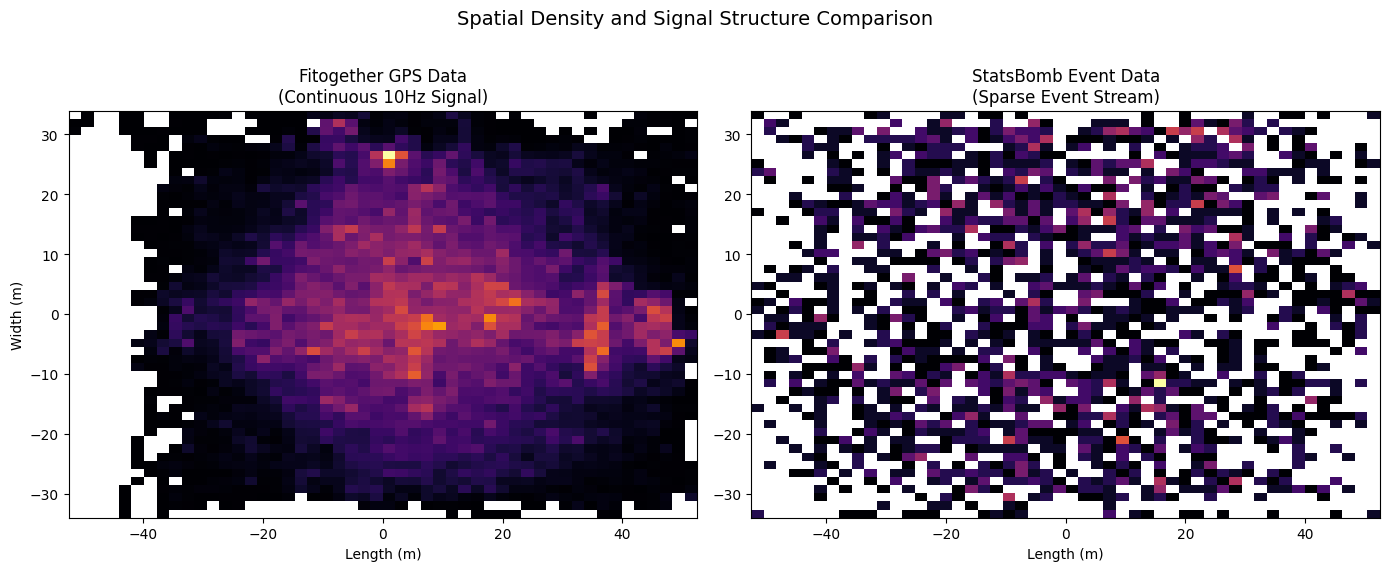

In [8]:
# Visualization
generate_heatmap_comparison(gps_data, sb_adapter.events if success else None, save_path='../figures/data-heatmap_comparison.png')

The visual comparison above illustrates the differences in spatial density and signal structure between the two datasets, highlighting the challenges in analyzing event-based data compared to continuous tracking data.